# Data Engineer Assessment - Carlos Cáceres Hernández

In [172]:
import io
import zipfile
import gdown
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data Ingestion

In [173]:
#Downloading data from Drive
data_url = 'https://drive.google.com/uc?id=1gT4UFYhphyA2fVo9NN9ODwVrkSMCT6Tr'
local_path = 'data.zip'
gdown.download(data_url, local_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1gT4UFYhphyA2fVo9NN9ODwVrkSMCT6Tr
To: C:\Users\carlo\Desktop\GitKraken\data.zip
100%|██████████| 2.49M/2.49M [00:00<00:00, 14.0MB/s]


'data.zip'

In [174]:
all_dfs = {}

with zipfile.ZipFile(local_path, 'r') as zip_file: 
    files = zip_file.namelist()
    print('Files to ingest:', files)
    print("\n")
    
    for file in files:
        file_name = file.split('/')[1] 
        if file_name != '' :
            print("Reading file: ",file_name)
            try:
                with zip_file.open(file) as f:
                    file_content = io.BytesIO(f.read())
                    all_dfs[file_name] = pd.read_csv(file_content)
                    all_dfs[file_name]['source_file'] = file_name
                    print("Success reading file: ",file_name, " shape: ",all_dfs[file_name].shape)
                    print("Data structure:")
                    print(all_dfs[file_name].dtypes)
            except Exception as e:
                print("Unexpected error reading file: ",file_name," error: ",e)
            print("\n")

Files to ingest: ['data/', 'data/Sales_December_2019.csv', 'data/Sales_April_2019.csv', 'data/Sales_February_2019.csv', 'data/Sales_March_2019.csv', 'data/Sales_August_2019.csv', 'data/Sales_May_2019.csv', 'data/Sales_November_2019.csv', 'data/Sales_October_2019.csv', 'data/Sales_January_2019.csv', 'data/Sales_September_2019.csv', 'data/Sales_July_2019.csv', 'data/Sales_June_2019.csv']


Reading file:  Sales_December_2019.csv
Success reading file:  Sales_December_2019.csv  shape:  (25117, 7)
Data structure:
Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
source_file         object
dtype: object


Reading file:  Sales_April_2019.csv
Success reading file:  Sales_April_2019.csv  shape:  (18383, 7)
Data structure:
Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
sour

Once all the files are loaded into dataframes and it is verified that they contain the same structure, we combine them to work with a single dataframe since the volume allows it.

In [175]:
#combining all dataframes
df = pd.concat(all_dfs.values(), ignore_index=True)
df.shape

(186850, 7)

In [176]:
df.dtypes

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
source_file         object
dtype: object

## Data cleaning and processing

### Understanding data

In [177]:
df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001",Sales_December_2019.csv
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001",Sales_December_2019.csv
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",Sales_December_2019.csv
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",Sales_December_2019.csv
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",Sales_December_2019.csv


In [178]:
#One row represents one order, or orders can have more than one row?
df.groupby('Order ID').size().sort_values(ascending=False).head(10)

Order ID
Order ID    355
160873        5
295681        4
212334        4
277875        4
304802        4
263918        4
226625        4
193511        4
296353        4
dtype: int64

In [179]:
#Checking one sample order
df[df['Order ID'] == '295681']

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file
16,295681,Google Phone,1,600,12/25/19 12:37,"79 Elm St, Boston, MA 02215",Sales_December_2019.csv
17,295681,USB-C Charging Cable,1,11.95,12/25/19 12:37,"79 Elm St, Boston, MA 02215",Sales_December_2019.csv
18,295681,Bose SoundSport Headphones,1,99.99,12/25/19 12:37,"79 Elm St, Boston, MA 02215",Sales_December_2019.csv
19,295681,Wired Headphones,1,11.99,12/25/19 12:37,"79 Elm St, Boston, MA 02215",Sales_December_2019.csv


In [180]:
#Checking if all the order lines are in the same file. Important when ingesting future files
df.groupby('Order ID')['source_file'].nunique().sort_values(ascending=False).head(10)

Order ID
Order ID    12
260196       1
260188       1
260189       1
260190       1
260191       1
260192       1
260193       1
260194       1
260195       1
Name: source_file, dtype: int64

In [181]:
#Some lines have the order id column filled with the value: "Order ID"
df[df['Order ID'] == 'Order ID'].head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file
254,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales_December_2019.csv
705,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales_December_2019.csv
1101,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales_December_2019.csv
2875,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales_December_2019.csv
3708,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Sales_December_2019.csv


In [182]:
#all theese rows have as value the header name. Need to clean this.
df[df['Order ID'] == 'Order ID'].groupby('Order ID').nunique()

,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file
Order ID,,,,,,
Order ID,1,1,1,1,1,12


### Data cleaning

In [183]:
#Deleting rows with header names
def columns_contains_header_name(x):
    for col in ['Order ID','Product','Quantity Ordered','Price Each','Order Date','Purchase Address']:
        if x[col] != col : 
            return True
    return False
    
df_no_header_rows = df[df.apply(columns_contains_header_name,axis=1)]

In [184]:
#checking if there are empty rows
df_no_header_rows[df_no_header_rows[['Order ID','Product','Quantity Ordered','Price Each','Order Date','Purchase Address']].isnull().all(axis=1)]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file
264,NaN,NaN,NaN,NaN,NaN,NaN,Sales_December_2019.csv
648,NaN,NaN,NaN,NaN,NaN,NaN,Sales_December_2019.csv
680,NaN,NaN,NaN,NaN,NaN,NaN,Sales_December_2019.csv
1385,NaN,NaN,NaN,NaN,NaN,NaN,Sales_December_2019.csv
1495,NaN,NaN,NaN,NaN,NaN,NaN,Sales_December_2019.csv
...,...,...,...,...,...,...,...
185795,NaN,NaN,NaN,NaN,NaN,NaN,Sales_June_2019.csv
185868,NaN,NaN,NaN,NaN,NaN,NaN,Sales_June_2019.csv
185887,NaN,NaN,NaN,NaN,NaN,NaN,Sales_June_2019.csv
185960,NaN,NaN,NaN,NaN,NaN,NaN,Sales_June_2019.csv


In [185]:
#Deleting empty rows
df_no_null_rows = df_no_header_rows.dropna(subset=['Order ID','Product','Quantity Ordered','Price Each','Order Date','Purchase Address'],how='all')
df_no_null_rows.shape

(185950, 7)

In [186]:
#Once deleted empty rows, checking columns with empty values
df_no_null_rows.isna().sum()

Order ID            0
Product             0
Quantity Ordered    0
Price Each          0
Order Date          0
Purchase Address    0
source_file         0
dtype: int64

In [187]:
#finding duplicates
df_no_null_rows[df_no_null_rows.duplicated()]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file
440,296081,Flatscreen TV,1,300,12/30/19 16:52,"970 Sunset St, Austin, TX 73301",Sales_December_2019.csv
1735,297311,Bose SoundSport Headphones,1,99.99,12/07/19 07:30,"858 Willow St, Los Angeles, CA 90001",Sales_December_2019.csv
2822,298358,Apple Airpods Headphones,1,150,12/04/19 15:57,"482 8th St, San Francisco, CA 94016",Sales_December_2019.csv
3131,298657,Lightning Charging Cable,1,14.95,12/01/19 18:22,"428 12th St, Atlanta, GA 30301",Sales_December_2019.csv
3377,298883,Wired Headphones,1,11.99,12/28/19 18:07,"516 Willow St, Los Angeles, CA 90001",Sales_December_2019.csv
...,...,...,...,...,...,...,...
182495,218756,AAA Batteries (4-pack),1,2.99,06/11/19 14:54,"362 Hickory St, Boston, MA 02215",Sales_June_2019.csv
182766,219007,AA Batteries (4-pack),1,3.84,06/24/19 11:16,"42 8th St, Los Angeles, CA 90001",Sales_June_2019.csv
184211,220392,Lightning Charging Cable,1,14.95,06/08/19 17:13,"472 8th St, Portland, ME 04101",Sales_June_2019.csv
184715,220882,Lightning Charging Cable,1,14.95,06/13/19 17:53,"588 Lake St, Boston, MA 02215",Sales_June_2019.csv


In [188]:
#checking one sample duplicated row
df_no_null_rows[df_no_null_rows['Order ID'] =='296081']

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file
439,296081,Flatscreen TV,1,300,12/30/19 16:52,"970 Sunset St, Austin, TX 73301",Sales_December_2019.csv
440,296081,Flatscreen TV,1,300,12/30/19 16:52,"970 Sunset St, Austin, TX 73301",Sales_December_2019.csv


In [189]:
#Dropping all duplicate rows. A product shouldn't appear twice in an order with the same price and quantity.
df_no_duplicates = df_no_null_rows.drop_duplicates()
df_no_duplicates.shape

(185686, 7)

### Data Transformation

It is necessary to cast and transform some columns

In [190]:
pd.options.mode.chained_assignment = None

In [191]:
#Trying to cast numeric columns
df_no_duplicates['Order ID'] = df_no_duplicates['Order ID'].astype(int)
df_no_duplicates['Quantity Ordered'] = df_no_duplicates['Quantity Ordered'].astype(int)
df_no_duplicates['Price Each'] = df_no_duplicates['Price Each'].astype(float)

In [192]:
#Trying to cast datetime column
df_no_duplicates['Order Date'] = pd.to_datetime(df_no_duplicates['Order Date'],format='%m/%d/%y %H:%M')

In [193]:
df_no_duplicates.dtypes

Order ID                     int32
Product                     object
Quantity Ordered             int32
Price Each                 float64
Order Date          datetime64[ns]
Purchase Address            object
source_file                 object
dtype: object

In [194]:
#Splitting Address column
df_no_duplicates[['street', 'city', 'state_pc']] = df_no_duplicates['Purchase Address'].str.split(', ', expand=True)

In [195]:
df_no_duplicates[['state','postal_code']] = df_no_duplicates['state_pc'].str.split(' ', expand=True)
df_no_duplicates = df_no_duplicates.drop(columns=['state_pc'])

In [196]:
df_no_duplicates.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file,street,city,state,postal_code
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",Sales_December_2019.csv,136 Church St,New York City,NY,10001
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",Sales_December_2019.csv,562 2nd St,New York City,NY,10001
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",Sales_December_2019.csv,277 Main St,New York City,NY,10001
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",Sales_December_2019.csv,410 6th St,San Francisco,CA,94016
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",Sales_December_2019.csv,43 Hill St,Atlanta,GA,30301


In [197]:
#Calculating total paid for each order line
df_no_duplicates['total_paid'] = df_no_duplicates['Price Each'] * df_no_duplicates['Quantity Ordered']

In [198]:
df_no_duplicates.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file,street,city,state,postal_code,total_paid
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",Sales_December_2019.csv,136 Church St,New York City,NY,10001,1700.00
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",Sales_December_2019.csv,562 2nd St,New York City,NY,10001,600.00
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",Sales_December_2019.csv,277 Main St,New York City,NY,10001,11.95
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",Sales_December_2019.csv,410 6th St,San Francisco,CA,94016,149.99
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",Sales_December_2019.csv,43 Hill St,Atlanta,GA,30301,11.95


### Checking Data Quality

Checking Data Quality after cleaning and transforming

In [199]:
#Checking products names are normalized (No duplicates with Capitalization errors, whitespaces...)
print(df_no_duplicates['Product'].unique())

['Macbook Pro Laptop' 'LG Washing Machine' 'USB-C Charging Cable'
 '27in FHD Monitor' 'AA Batteries (4-pack)' 'Bose SoundSport Headphones'
 'AAA Batteries (4-pack)' 'ThinkPad Laptop' 'Lightning Charging Cable'
 'Google Phone' 'Wired Headphones' 'Apple Airpods Headphones'
 'Vareebadd Phone' 'iPhone' '20in Monitor' '34in Ultrawide Monitor'
 'Flatscreen TV' '27in 4K Gaming Monitor' 'LG Dryer']


In [200]:
#Checking cities and states columns are normalized
print('cities:',df_no_duplicates['city'].unique())
print('states:',df_no_duplicates['state'].unique())

cities: ['New York City' 'San Francisco' 'Atlanta' 'Portland' 'Dallas'
 'Los Angeles' 'Boston' 'Austin' 'Seattle']
states: ['NY' 'CA' 'GA' 'OR' 'TX' 'MA' 'ME' 'WA']


In [201]:
#checking date inconsistencies in orders (Order date changes between 2 of their lines)
df_no_duplicates.groupby('Order ID')['Order Date'].nunique().sort_values(ascending=False)

Order ID
141234    1
260196    1
260188    1
260189    1
260190    1
         ..
200714    1
200715    1
200716    1
200717    1
319670    1
Name: Order Date, Length: 178437, dtype: int64

In [202]:
#checking address inconsistencies in orders (Order Address changes between 2 of their lines)
df_no_duplicates.groupby('Order ID')['Purchase Address'].nunique().sort_values(ascending=False)

Order ID
141234    1
260196    1
260188    1
260189    1
260190    1
         ..
200714    1
200715    1
200716    1
200717    1
319670    1
Name: Purchase Address, Length: 178437, dtype: int64

In [203]:
df_clean = df_no_duplicates

In [204]:
df_clean.shape

(185686, 12)

## Metrics and Data Visualization

#### What was the best month for sales? How much was earned that month?

In [205]:
df_sales_by_month = df_clean.groupby(df_clean['Order Date'].dt.to_period('M')) \
                            .agg({'Order ID': 'nunique','total_paid': 'sum'}).reset_index() \
                            .rename(columns={'Order Date': 'Month', 'Order ID': 'Orders', 'total_paid': 'Earnings'})

In [206]:
df_sales_by_month.sort_values(by='Earnings', ascending=False).head()

,Month,Orders,Earnings
11,2019-12,24004,4608295.70
9,2019-10,19436,3734777.86
3,2019-04,17528,3389217.98
10,2019-11,16859,3197875.05
4,2019-05,15836,3150616.23


C:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


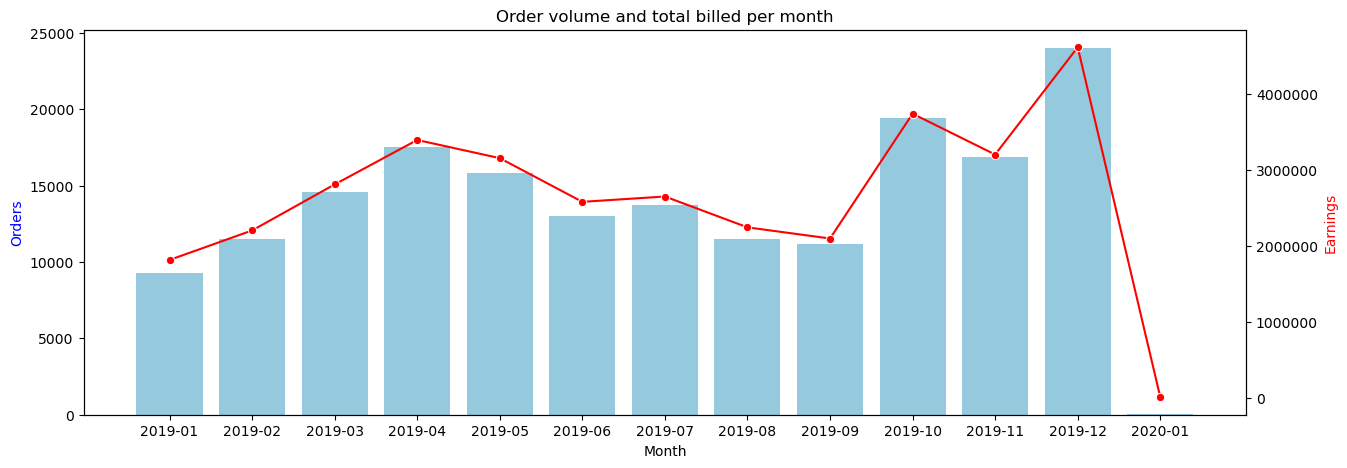

In [207]:
df_sales_by_month['Month'] = df_sales_by_month['Month'].astype(str)

fig, ax1 = plt.subplots(figsize=(15, 5))
sns.barplot(x='Month', y='Orders', data=df_sales_by_month, color='skyblue', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(x='Month', y='Earnings', data=df_sales_by_month, marker='o', color='red', ax=ax2)
ax1.set_ylabel('Orders', color='blue')
ax2.set_ylabel('Earnings', color='red')
ax2.ticklabel_format(style='plain', axis='y')
#ax1.set_xlabel('Month')
ax1.set_title('Order volume and total billed per month')
plt.show()

* **ANSWER:** The best month for sales was December 2019, with 24,004 orders recorded, meaning that more than 4.5 million dollars were earned. 

### What city sold the most product?

In [208]:
df_sales_by_city = df_clean.groupby('city')['Quantity Ordered'].sum().reset_index().sort_values(by='Quantity Ordered', ascending=False)

In [209]:
df_sales_by_city.head(1)

,city,Quantity Ordered
7,San Francisco,50169


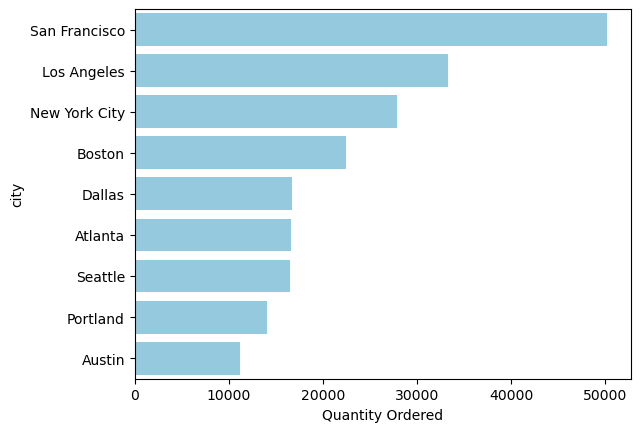

In [210]:
sns.barplot(y='city', x='Quantity Ordered', data=df_sales_by_city, color='skyblue')
plt.show()

* **ANSWER:** The city that sold the most products was San Francisco, having sold a total of 50,169 products.

### What product sold the most? Why do you think it sold the most?

In [211]:
df_sales_by_product = df_clean.groupby(['Product','Price Each'])['Quantity Ordered'].sum().reset_index().sort_values(by='Quantity Ordered', ascending=False)

In [212]:
df_sales_by_product

,Product,Price Each,Quantity Ordered
5,AAA Batteries (4-pack),2.99,30986
4,AA Batteries (4-pack),3.84,27615
15,USB-C Charging Cable,11.95,23931
12,Lightning Charging Cable,14.95,23169
17,Wired Headphones,11.99,20524
6,Apple Airpods Headphones,150.00,15637
7,Bose SoundSport Headphones,99.99,13430
2,27in FHD Monitor,149.99,7541
18,iPhone,700.00,6847
1,27in 4K Gaming Monitor,389.99,6239


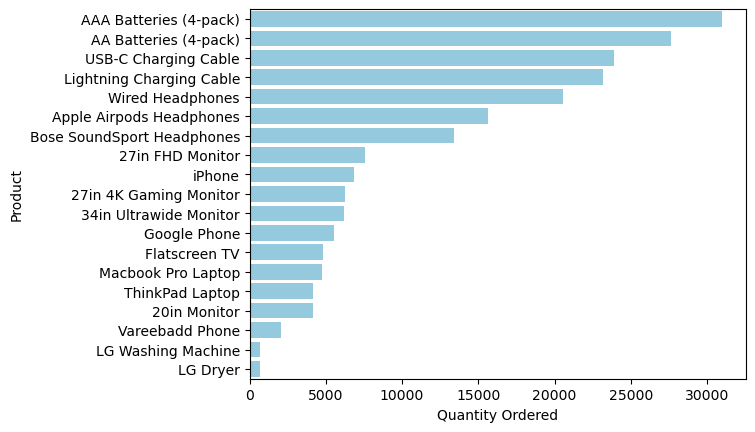

In [213]:
sns.barplot(y='Product', x='Quantity Ordered', data=df_sales_by_product, color='skyblue')
plt.show()

* **ANSWER:** The best-selling product is the "AAA Batteries (4-pack)," which has the lowest price, followed by the "AA Batteries (4-pack)," the second best-selling product. Both products have in common that they are single-use batteries, making them items that need to be purchased repeatedly.

### In which time range are the orders concentrated?

In [214]:
df_orders_by_time = df_clean.copy()
df_orders_by_time['dayofweek'] = df_orders_by_time['Order Date'].dt.day_name()
df_orders_by_time['hour'] = df_orders_by_time['Order Date'].dt.hour
df_orders_by_time = df_orders_by_time.groupby(['dayofweek', 'hour'])['Order ID'].nunique().reset_index().rename(columns={'Order ID': 'Orders'})
df_orders_by_time_pivot = df_orders_by_time.pivot(index='hour', columns='dayofweek', values='Orders')
order_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_orders_by_time_pivot=df_orders_by_time_pivot[order_days]

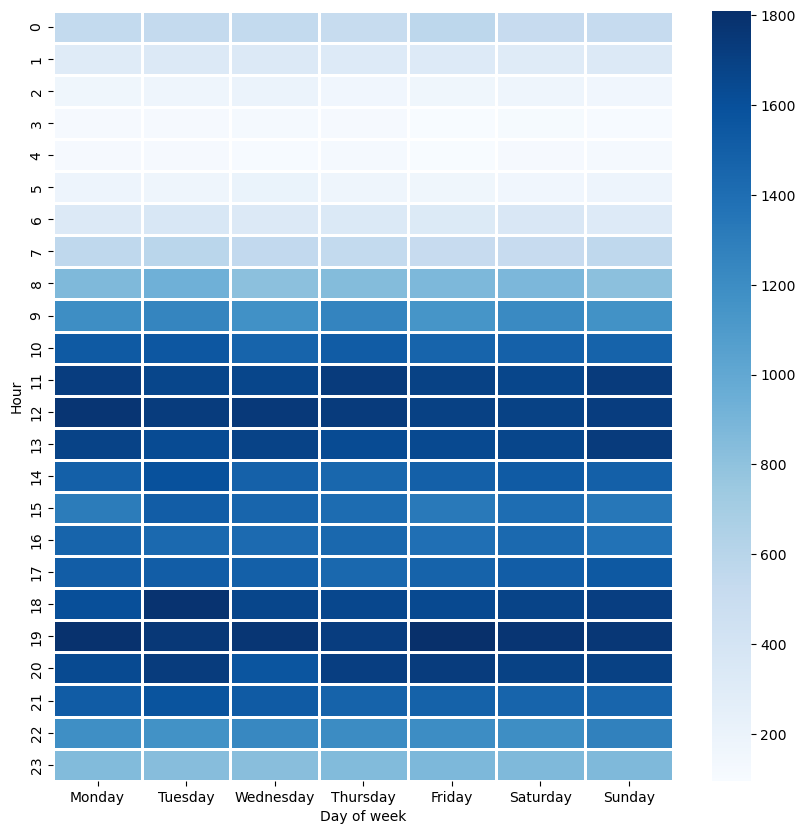

In [215]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_orders_by_time_pivot, cmap="Blues", linewidths=1)
plt.xlabel('Day of week')
plt.ylabel('Hour')
plt.show()

* **ANSWER:** The time range with the highest volume of orders is from 8 AM to 9 PM, with a slightly higher volume between 11 AM and 1 PM, and between 6 PM and 8 PM. As for the days of the week, the distribution is similar.

### How has the average order price evolved?

In [216]:
df_orders=df_clean.groupby(['Order ID','Order Date'])['total_paid'].sum().reset_index()
df_price_per_month=df_orders.groupby(df_orders['Order Date'].dt.to_period('M'))['total_paid'].mean().reset_index()\
                            .rename(columns={'Order Date': 'Month', 'total_paid': 'avg_order_price'})

In [217]:
df_price_per_month

,Month,avg_order_price
0,2019-01,195.718297
1,2019-02,191.377704
2,2019-03,192.794924
3,2019-04,193.360223
4,2019-05,198.952780
5,2019-06,198.343225
6,2019-07,192.316061
7,2019-08,195.148325
8,2019-09,186.972477
9,2019-10,192.157741


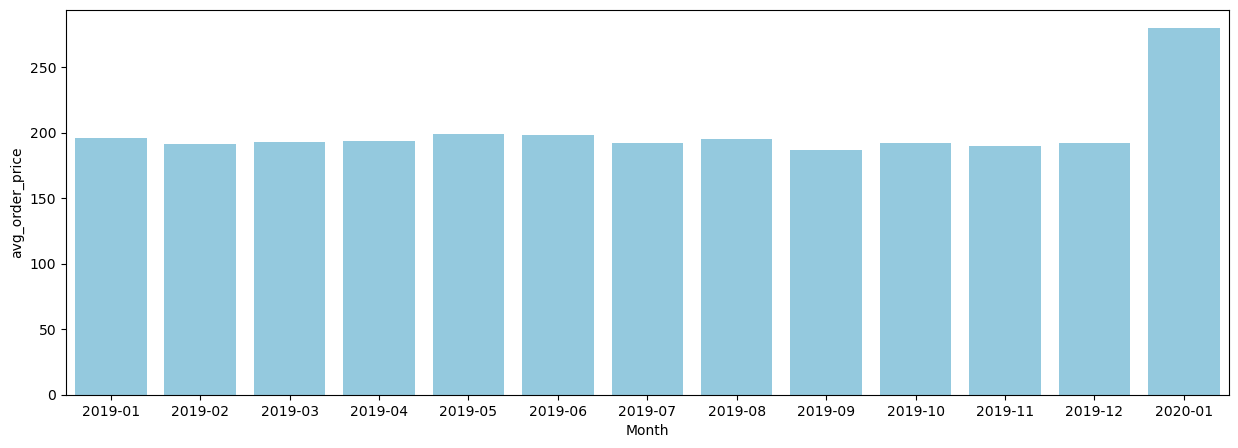

In [218]:
fig = plt.subplots(figsize=(15, 5))
df_price_per_month['Month'] = df_sales_by_month['Month'].astype(str)
sns.barplot(x='Month', y='avg_order_price', data=df_price_per_month, color='skyblue')
plt.show()

* **ANSWER:** Discarding the value obtained for January 2020 due to its low order volume, as it may be incomplete and causing an abnormal value in this metric. The average price has not changed and has remained slightly below 200 USD.

## Loading data to storage

In this section, the data will be uploaded to S3 partitioned by month.

In [219]:
import boto3

In [220]:
df_clean.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,source_file,street,city,state,postal_code,total_paid
0,295665,Macbook Pro Laptop,1,1700.00,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",Sales_December_2019.csv,136 Church St,New York City,NY,10001,1700.00
1,295666,LG Washing Machine,1,600.00,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",Sales_December_2019.csv,562 2nd St,New York City,NY,10001,600.00
2,295667,USB-C Charging Cable,1,11.95,2019-12-12 18:21:00,"277 Main St, New York City, NY 10001",Sales_December_2019.csv,277 Main St,New York City,NY,10001,11.95
3,295668,27in FHD Monitor,1,149.99,2019-12-22 15:13:00,"410 6th St, San Francisco, CA 94016",Sales_December_2019.csv,410 6th St,San Francisco,CA,94016,149.99
4,295669,USB-C Charging Cable,1,11.95,2019-12-18 12:38:00,"43 Hill St, Atlanta, GA 30301",Sales_December_2019.csv,43 Hill St,Atlanta,GA,30301,11.95


In [221]:
s3_client = boto3.client('s3',aws_access_key_id='**********',aws_secret_access_key='**********',region_name='**********')

In [222]:
bucket_name = 'sales-pipeline2'
base_path = 'orders/'

In [223]:
months = df_clean['Order Date'].dt.to_period('M').unique()
for month in months:
    date_month = str(month).split('-')[1]
    date_year = str(month).split('-')[0]
    key = base_path+'year='+date_year+'/month='+date_month+'/data.csv'
    print(f"Uploading data month: {date_year}-{date_month} to s3 key: {key}")
    try:
        csv_buffer = io.StringIO()
        df_load = df_clean[df_clean['Order Date'].dt.to_period('M') == month]
        df_load.to_csv(csv_buffer, index=False)
        s3_client.put_object(Bucket=bucket_name,Key=key,Body=csv_buffer.getvalue())
        print("Loaded file to s3. ",df_load.shape[0]," rows")
    except Exception as e:
        print("Unexpected error loading file to S3:", e)
    print("\n")

Uploading data month: 2019-12 to s3 key: orders/year=2019/month=12/data.csv
Loaded file to s3.  24944  rows


Uploading data month: 2020-01 to s3 key: orders/year=2020/month=01/data.csv
Loaded file to s3.  34  rows


Uploading data month: 2019-04 to s3 key: orders/year=2019/month=04/data.csv
Loaded file to s3.  18257  rows


Uploading data month: 2019-05 to s3 key: orders/year=2019/month=05/data.csv
Loaded file to s3.  16552  rows


Uploading data month: 2019-02 to s3 key: orders/year=2019/month=02/data.csv
Loaded file to s3.  11957  rows


Uploading data month: 2019-03 to s3 key: orders/year=2019/month=03/data.csv
Loaded file to s3.  15128  rows


Uploading data month: 2019-08 to s3 key: orders/year=2019/month=08/data.csv
Loaded file to s3.  11943  rows


Uploading data month: 2019-09 to s3 key: orders/year=2019/month=09/data.csv
Loaded file to s3.  11603  rows


Uploading data month: 2019-06 to s3 key: orders/year=2019/month=06/data.csv
Loaded file to s3.  13535  rows


Uploading dat